In [1]:
import numpy as np
from PIL import Image
import json
import os
import copy
import argparse
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tomo2mesh.projects.steel_am.coarse2fine import coarse_map, process_subset
from tomo2mesh.misc.voxel_processing import TimerGPU
from tomo2mesh.structures.voids import Voids
from tomo2mesh.porosity.params_3dunet import *
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all

import cupy as cp
import tomo2mesh.fbp.subset as subset
import cupyx.scipy as cpsp
import tomo2mesh.misc.voxel_processing as vp
import skimage.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('working_dir/demo_out/cur_config.json', 'r') as config_f:
    config = json.load(config_f)

output_prefix = 'working_dir/demo_out'

if not os.path.exists(output_prefix):
    os.mkdir(output_prefix)

prefix = config['img_dir']
start_file = config['img_range'][0]
end_file = config['img_range'][1]
omega = np.asarray(config['omega'])

omega = np.asarray(config['omega'])
omega = omega / 180 * np.pi # NOTE: Why 1pi and not 2pi

projs = []
for im_idx in tqdm(range(start_file, end_file + 1), desc='Loading imgs'):
    im = Image.open(os.path.join(prefix, config['img_prefix'] + f'_{im_idx:06d}.tif'))
    projs.append(np.array(im))
projs = np.stack(projs)
projs = projs.swapaxes(0,1)

if 'center' not in config:
    center = projs.shape[-1]/2.0 # assuming that object is perfectly centered
else:
    center = config['center']

if projs.shape[1] != len(omega):
    raise ValueError("Number of projections and omegas are not equal!")

b=2
b_K = 2

"""
voids_b.export_void_mesh_mproc("sizes", edge_thresh=0).write_ply(
    os.path.join(output_prefix, 
    f"{config['img_prefix']}_{config['img_range'][0]}_{config['img_range'][1]}_sandbox.ply"))
"""

Loading imgs: 100%|██████████| 1801/1801 [00:06<00:00, 289.33it/s]


'\nvoids_b.export_void_mesh_mproc("sizes", edge_thresh=0).write_ply(\n    os.path.join(output_prefix, \n    f"{config[\'img_prefix\']}_{config[\'img_range\'][0]}_{config[\'img_range\'][1]}_sandbox.ply"))\n'

In [3]:
# def coarse_map(projs, theta, center, b, b_K, dust_thresh):

memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)

# fbp
raw_data = projs[::b,::b_K,::b], omega[::b_K,...], center/b
# V = cp.empty((nz,n,n), dtype = cp.float32)
V = subset.recon_all_gpu(*raw_data)

In [4]:
print(V.shape)
print(type(V))

(600, 960, 960)
<class 'cupy.ndarray'>


In [11]:
def plot_pipeline(original, processed, recon_slice):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].imshow(original[recon_slice])
    ax[0].set_title('Orignal')
    ax[1].imshow(processed[recon_slice])
    ax[1].set_title('Post Processsing')
    return fig

In [6]:
recon_original = cp.asnumpy(V)

In [7]:
V[:] = cpsp.ndimage.gaussian_filter(V,0.5)
pipeline_v = cp.asnumpy(V)

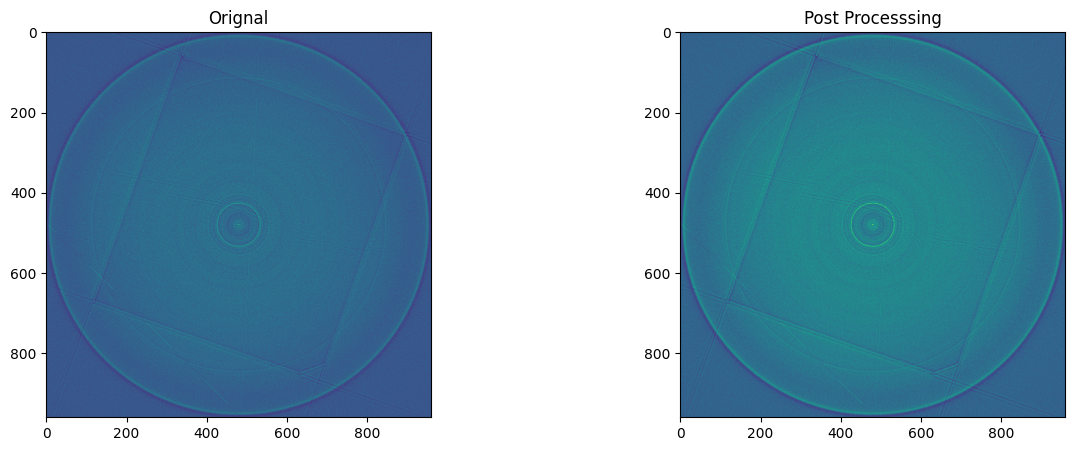

In [14]:
_ = plot_pipeline(recon_original, pipeline_v, 500)

In [9]:
V_np_2 = cp.asnumpy(V)

In [10]:
V[:] = cpsp.ndimage.gaussian_filter(V,0.5)

# binarize
voxel_values = vp.get_values_cyl_mask(V[::2,::2,::2], 1.0).get()
rec_min_max = vp.modified_autocontrast(voxel_values, s=0.01)
thresh = cp.float32(filters.threshold_otsu(voxel_values))    
V[:] = (V<thresh).astype(cp.uint8)
vp.cylindrical_mask(V,0.95,1)

# connected components labeling
V = cp.array(V, dtype = cp.uint32)
V[:], n_det = cpsp.ndimage.label(V,structure = cp.ones((3,3,3),dtype=cp.uint8))    

voids_b = Voids().count_voids(V.get(), b, dust_thresh, pad_bb = 2)    

voids_b["rec_min_max"] = rec_min_max

del V
memory_pool.free_all_blocks()    

NameError: name 'dust_thresh' is not defined